<div class="list-group" id="list-tab" role="tablist">
<h1 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; border:0; color:#dfbf9f' role="tab" aria-controls="home"><center>CIFAR-10 - Object Recognition in Images usnig ResNet</center></h1>

<a id="1"></a>
<div class="list-group" id="list-tab" role="tablist">
<h1 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; border:0; color:#dfbf9f' role="tab" aria-controls="home"><center>About Dataset</center></h1>

`CIFAR-10  is an established computer-vision dataset used for object recognition. It is a subset of the 80
 million tiny images dataset and consists of 60,000 32x32 color images containing one of 10 object classes, 
 with 6000 images per class. It was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton.`



![cifar10](https://miro.medium.com/max/709/1*LyV7_xga4jUHdx4_jHk1PQ.png)

<div class="list-group" id="list-tab" role="tablist">
<h1 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; border:0; color:#dfbf9f' role="tab" aria-controls="home"><center>Table of Contents</center></h1>

- [Import Libaries](#1)
- [Exploring the Data](#2)     
- [Data Transformation (Data Normalisation and Data Augmentation)](#3)
- [GPU Helper Functions](#4)
- [ResNet](#5)
- [Training the model](#6)
- [Conclusion](#7)

<a id="1"></a>
# Import Libaries

In [1]:
# importing libraries
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision import datasets,transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor,ToPILImage
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tt
import numpy as np

<a id="3"></a>
# Data Transformation (Data Normalisation and Data Augmentation)

In [2]:
stats= ((0.4914,0.4822,0.4465),(0.2023,0.1994,0.2010)) #mean and std
train_tfm= tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), # transormation of data together
                       tt.RandomHorizontalFlip(),
                       tt.ToTensor(),tt.Normalize(*stats,inplace=True)])
valid_tfm = tt.Compose([tt.ToTensor(),tt.Normalize(*stats)])

In [3]:
# Image transformation
train_ds = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_tfm) # Data augmentation is only done on training images
valid_ds = datasets.CIFAR10(root='./data', train=False, download=True, transform=valid_tfm)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_ds

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )

In [5]:
img, label= train_ds[0]
print(img.shape,label)
img

torch.Size([3, 32, 32]) 6


tensor([[[-0.1029, -0.1416,  0.0910,  ..., -2.1189, -1.9444, -2.1189],
         [-0.1223, -0.0447,  0.1491,  ..., -2.4291, -2.1189, -2.4291],
         [ 0.5174,  0.6338,  0.6338,  ..., -1.5955, -1.2854, -1.5955],
         ...,
         [-0.0253,  1.5642,  1.5061,  ...,  1.3122,  1.7581,  1.3122],
         [-1.3435,  0.9245,  1.1765,  ...,  1.4673,  1.8356,  1.4673],
         [-1.3435,  0.6725,  0.2267,  ...,  1.4673,  1.6030,  1.4673]],

        [[-0.7662, -0.7662, -0.5696,  ..., -2.2806, -1.9463, -2.2806],
         [-0.7859, -0.6876, -0.5302,  ..., -2.4183, -2.0249, -2.4183],
         [ 0.0401,  0.1778,  0.1384,  ..., -1.5136, -1.1989, -1.5136],
         ...,
         [-0.5892,  0.9841,  0.8661,  ...,  0.2564,  1.0038,  0.2564],
         [-1.8479,  0.4138,  0.6301,  ...,  0.5318,  1.1611,  0.5318],
         [-1.8086,  0.1974, -0.3532,  ...,  0.5908,  0.9251,  0.5908]],

        [[-1.2459, -1.2459, -1.0898,  ..., -2.2214, -1.8117, -2.2214],
         [-1.2459, -1.1483, -1.0508,  ..., -2

In [6]:
def show_image(img,label):
    print('Label: ', train_ds.classes[label],"("+str(label)+")")
    plt.imshow(img.permute(1,2,0))

Label:  ship (8)


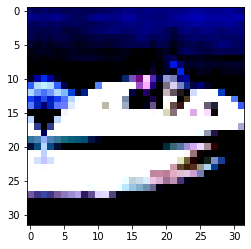

In [7]:
show_image(train_ds[222][0],train_ds[222][1])

Label:  horse (7)


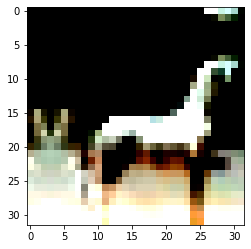

In [8]:
show_image(*train_ds[1543])

Label:  airplane (0)


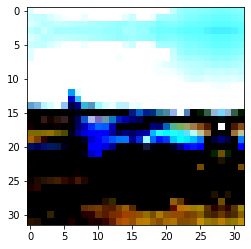

In [9]:
show_image(*train_ds[453])

We'll use a relatively large batch size of 400 to utlize a larger portion of the GPU RAM.

In [10]:
batch_size=400

In [11]:
# Dataloader to load data in batches(mini batch)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size, shuffle=True) # Batch size of 400 i.e to work with 400 images at a time
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False)

Let's take a look at some sample images in batch from the training dataloader.

In [12]:
def show_batch(dl):
    for images, labels in dl:
        fig,ax= plt.subplots(figsize=(12,12))
        ax.set_xticks([]) #hide ticks
        ax.set_yticks([])
        ax.imshow(make_grid(images[:64],nrow=8).permute(1,2,0))
        break # printing only first 64 images from first batch

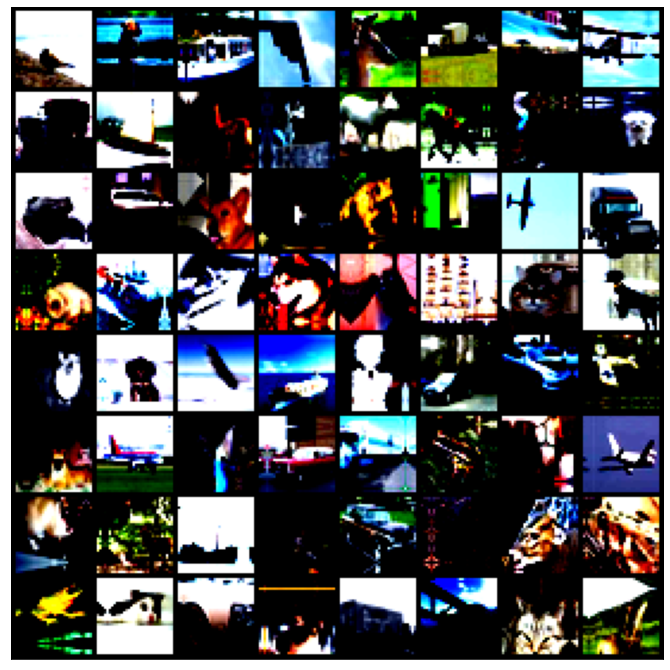

In [13]:
show_batch(train_dl)

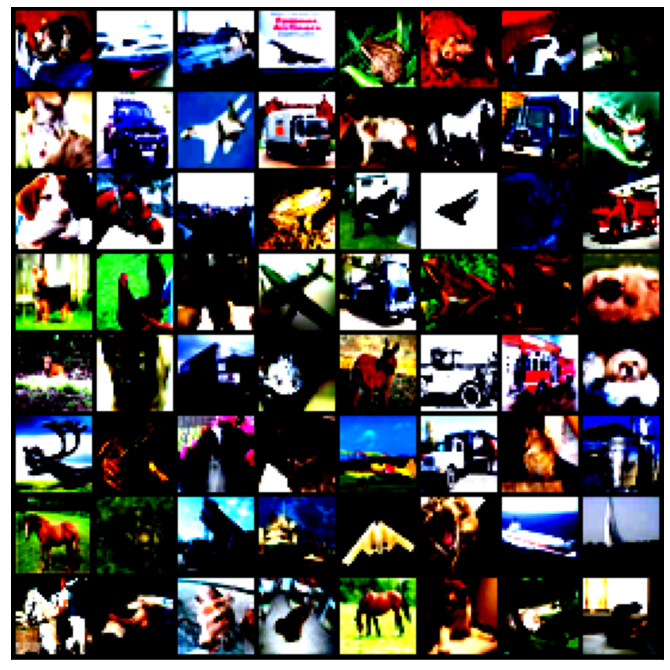

In [14]:
show_batch(valid_dl)

<a id="4"></a>
# GPU Helper Functions

To use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU as required.

In [15]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [16]:
device = get_default_device()
device

device(type='cuda')

We can now wrap our training and validation data loaders using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available).

In [17]:
train_dl= DeviceDataLoader(train_dl,device)
valid_dl = DeviceDataLoader(valid_dl, device)


![resnet-9](https://miro.medium.com/max/1140/1*D0F3UitQ2l5Q0Ak-tjEdJg.png)


In [18]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


<a id="5"></a>
# ResNet

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 32

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.linear = nn.Linear(256*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def MyResNet():
  return ResNet(BasicBlock, [6, 5, 4, 3])     #My Residual Network

def MyResNet2():
  return ResNet(BasicBlock, [0, 0, 0, 0])     #My Residual Network2

In [20]:

model = MyResNet().to(device)

In [21]:
from torchsummary import summary
summary(model,(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 32, 32]           9,216
       BatchNorm2d-4           [-1, 32, 32, 32]              64
            Conv2d-5           [-1, 32, 32, 32]           9,216
       BatchNorm2d-6           [-1, 32, 32, 32]              64
        BasicBlock-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 32, 32, 32]           9,216
       BatchNorm2d-9           [-1, 32, 32, 32]              64
           Conv2d-10           [-1, 32, 32, 32]           9,216
      BatchNorm2d-11           [-1, 32, 32, 32]              64
       BasicBlock-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 32, 32, 32]           9,216
      BatchNorm2d-14           [-1, 32,

<a id="6"></a>
## Training the model

Before we train the model, we're going to make a bunch of small but important improvements to our `fit` function:

* **Learning rate scheduling**: Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. There are many strategies for varying the learning rate during training, and the one we'll use is called the **"One Cycle Learning Rate Policy"**, which involves starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% of epochs, then gradually decreasing it to a very low value for the remaining epochs. Learn more: https://sgugger.github.io/the-1cycle-policy.html

* **Weight decay**: We also use weight decay, which is yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function.Learn more: https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab

* **Gradient clipping**: Apart from the layer weights and outputs, it also helpful to limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values. This simple yet effective technique is called gradient clipping. Learn more: https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48


Let's define a `fit_one_cycle` function to incorporate these changes. We'll also record the learning rate used for each batch.

`Need to use NO_GRAD to keep the update out of the gradient computationIt boils down to the DYNAMIC GRAPH that PyTorch uses. 
It allows us to perform regular Python operations on tensors, independent of PyTorch’s computation graph.``

In [22]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()  # Realsing cuda memory otherwise might get cuda out of memory error
    history = []
    
    #custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train() #Setting training mode
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [23]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.3034818172454834, 'val_acc': 0.10000000149011612}]

In [24]:
epochs = 70
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-6
opt_func = torch.optim.Adam

In [25]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], train_loss: 1.5749, val_loss: 1.3762, val_acc: 0.5018
Epoch [1], train_loss: 1.1436, val_loss: 1.1744, val_acc: 0.5855
Epoch [2], train_loss: 0.9352, val_loss: 0.9496, val_acc: 0.6675
Epoch [3], train_loss: 0.8097, val_loss: 1.0228, val_acc: 0.6699
Epoch [4], train_loss: 0.7077, val_loss: 0.9337, val_acc: 0.7056
Epoch [5], train_loss: 0.6335, val_loss: 1.4831, val_acc: 0.5975
Epoch [6], train_loss: 0.5880, val_loss: 0.8003, val_acc: 0.7528
Epoch [7], train_loss: 0.5531, val_loss: 0.7719, val_acc: 0.7493
Epoch [8], train_loss: 0.5127, val_loss: 0.8469, val_acc: 0.7281
Epoch [9], train_loss: 0.4887, val_loss: 0.8837, val_acc: 0.7154
Epoch [10], train_loss: 0.4556, val_loss: 0.7244, val_acc: 0.7710
Epoch [11], train_loss: 0.4248, val_loss: 0.7101, val_acc: 0.7865
Epoch [12], train_loss: 0.4018, val_loss: 0.7475, val_acc: 0.7609
Epoch [13], train_loss: 0.3816, val_loss: 0.7491, val_acc: 0.7792
Epoch [14], train_loss: 0.3643, val_loss: 0.4475, val_acc: 0.8523
Epoch [15], train_lo

In [26]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.figure(figsize=(10,6))
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

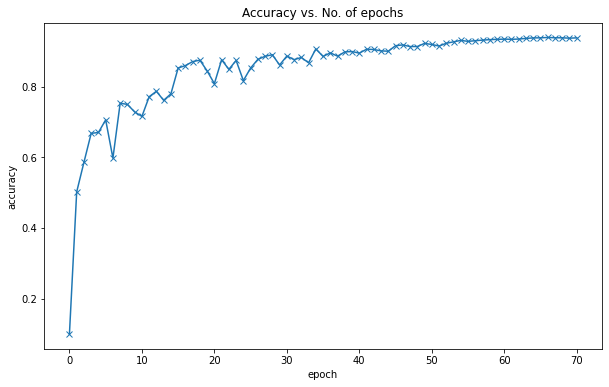

In [27]:

plot_accuracies(history)

In [28]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.figure(figsize=(10,6))
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

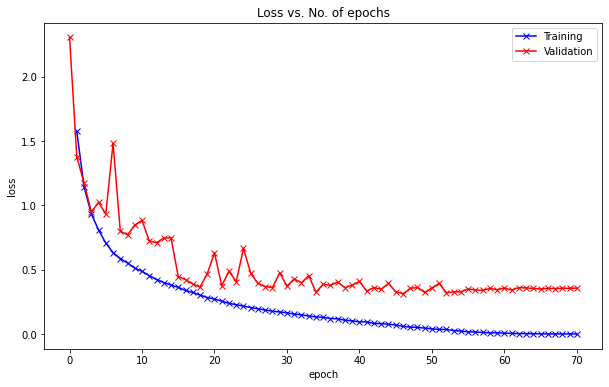

In [29]:
plot_losses(history)

It's clear from the trend that our model isn't overfitting to the training data just yet. Finally, let's visualize how the learning rate changed over time, batch-by-batch over all the epochs.

In [30]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.figure(figsize=(10,6))
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

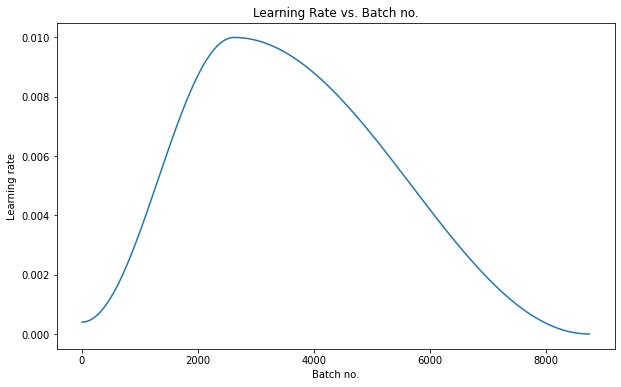

In [31]:
plot_lrs(history)

`As expected, the learning rate starts at a low value, and gradually increases for 30% of the iterations to a 
maximum value of `0.01`, and then gradually decreases to a very small value as per leslie smith.`

<a id="7"></a>
# Conclusion

<div class="list-group" id="list-tab" role="tablist">
<h1 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; border:0; color:#dfbf9f' role="tab" aria-controls="home"><center>Validation Accuracy ~ 93% </center></h1>
